## Final Task:
This is your final evaluation for the project. As decided, we will be predicting images of people into three classes: `without_mask`, `mask_weared_incorrect` and `with_mask`. 

In [ ]:
import tensorflow as tf

### Loading the dataset
Make a copy of the dataset given to you in your Google Drive (keep it outside, don't put it in any folder to avoid inconvenience). Ensure it is named as `Mask_Dataset` or change the path (the variable `data_dir`) accordingly.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib

path='/content/drive/MyDrive/Mask_Dataset/'
data_dir = pathlib.Path(path)

### Know the Dataset
Most of the code is written for you as you aren't used to these libraries. You are to go through the documentation for your benefit.

In [ ]:
# Print image count
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8982


In [ ]:
# Print Output Labels
import os
output_classes = os.listdir(data_dir)
print(output_classes)

['without_mask', 'with_mask', 'mask_weared_incorrect']


[2994, 2994, 2994]


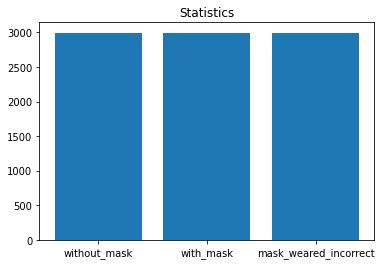

In [ ]:
# Plot count of each ouput label
import matplotlib.pyplot as plt

count=[]
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count=os.listdir(dir)
  count.append(len(im_count))

print(count)

plt.bar(output_classes,count)
plt.title("Statistics")
plt.show()

without_mask


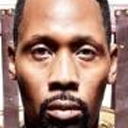

without_mask


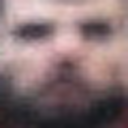



with_mask


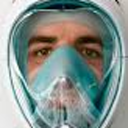

with_mask


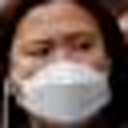



mask_weared_incorrect


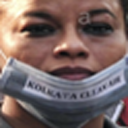

mask_weared_incorrect


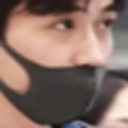

In [ ]:
# Check some sample images (Use of cv2)
import cv2
from google.colab.patches import cv2_imshow

for label in output_classes:
  this_path=path+label
  image_path=this_path+'/1.png'
  print(label)
  image=cv2.imread(image_path)
  cv2_imshow(image)
  image_path=this_path+'/2.png'
  print(label)
  image=cv2.imread(image_path)
  cv2_imshow(image)
  print("\n")


In [ ]:
# Check shape of the images in your dataset. This will be helpful while specifying input_shape in your Transfer Learning Model
dimen=image.shape
print(dimen)

(128, 128, 3)


In [ ]:
# Check if all the images have same shape, else you need to resize them to some common size
# The code provided as it is above in the template will help
import glob 

image_count = len(list(data_dir.glob('*/*.png')))
paths = list(glob.glob(path+'*/*.png')) 
flag=0
for image_path in paths:
  image=cv2.imread(image_path)
  d1=image.shape
  if d1!=dimen:
    flag=1
    print('Different shape')
  else:
      print('Same shape')

In [ ]:
# If the shape is variable, reshape to a common size 
# If it is same, prove it
if flag==0:
  print("All images are of same size")
else:
  print("Different Size Images found")

All imges are of same size


### Model Definition
Choose a model for Transfer Learning (You may also experment with multiple models and keep all of them in this notebook)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
# Choose and define base model
from tensorflow.keras.applications.vgg16 import VGG16

baseModel = VGG16(weights="imagenet", include_top=False,
	input_shape=dimen)

In [ ]:
# Print base model summary and have a look at the layers
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# As we're using Transfer Learning, you do not need to train all the layers. Freeze all of the layers or train some layers (experiment)
baseModel.trainable = False


In [ ]:
# Append Fully connected/custom Conv2D/Dropout/MaxPooling layers to the base model
model=baseModel.output
model=Flatten(name="flatten")(model)
model=Dense(128, activation="relu")(model)
model=Dropout(0.5)(model)
model=Dense(3, activation="softmax")(model)

In [ ]:
# Add the final output layer
finalmodel = Model(inputs=baseModel.input, outputs=model)

In [ ]:
# Print your model's summary
finalmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
# Compile you model (set the parameters like loss/optimizers/metrics)
finalmodel.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

### Data Augmentation and Pre-processing
Augment the data. You may also try dyanamic augmentation using [`tf.keras.preprocessing.image.ImageDataGenerator `](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).   
You may use [`tf.keras.applications.vgg16.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)(or some other base model's utility) for pre-processing (can also be passed as a parameter to `ImageDataGenerator`)

In [ ]:
from keras.applications.vgg16 import preprocess_input # Change according to your base model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
  validation_split=0.2)

### Training and Validation Dataset  
Split the dataset into training and validation (We'll be looking for your validation accuracy, assume we are using complete dataset for now). 

Hint: `flow_from_directory` used with `ImageDataGenerator` will simplify things for you.

In [ ]:
train_dataset = data_aug.flow_from_directory(batch_size=64,
                                          directory=path, 
                                          target_size=(128, 128),
                                          subset="training",
                                          class_mode='categorical')
validation_dataset = data_aug.flow_from_directory(batch_size=64,
                                                 directory=path, 
                                                 target_size=(128, 128),
                                                 subset="validation",
                                                 class_mode='categorical')

Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


### Training  
Train your model for some epochs and plot the graph. Try and save your best model. Experiment with the parameters of `model.fit`

In [ ]:
from keras.callbacks import ModelCheckpoint
r = finalmodel.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=20,
  steps_per_epoch=len(train_dataset),
  validation_steps= len(validation_dataset)
)
# ModelCheckpoint is helpful to save the model giving best results (brownie points)

Epoch 1/20
113/113 [==============================] - 289s 3s/step - loss: 1.4031 - accuracy: 0.8161 - val_loss: 0.2691 - val_accuracy: 0.9130
Epoch 2/20
113/113 [==============================] - 50s 439ms/step - loss: 0.3030 - accuracy: 0.8939 - val_loss: 0.1901 - val_accuracy: 0.9443
Epoch 3/20
113/113 [==============================] - 49s 438ms/step - loss: 0.2545 - accuracy: 0.9168 - val_loss: 0.1505 - val_accuracy: 0.9599
Epoch 4/20
113/113 [==============================] - 50s 439ms/step - loss: 0.2109 - accuracy: 0.9325 - val_loss: 0.1251 - val_accuracy: 0.9677
Epoch 5/20
113/113 [==============================] - 49s 436ms/step - loss: 0.2014 - accuracy: 0.9380 - val_loss: 0.1559 - val_accuracy: 0.9576
Epoch 6/20
113/113 [==============================] - 50s 440ms/step - loss: 0.1835 - accuracy: 0.9384 - val_loss: 0.1400 - val_accuracy: 0.9654
Epoch 7/20
113/113 [==============================] - 49s 437ms/step - loss: 0.1688 - accuracy: 0.9456 - val_loss: 0.1354 - val_accu